# Data Mining Challange: *Reddit Gender Text-Classification* 

### Modules

In [ ]:
# Numpy & matplotlib for notebooks 
%pylab inline

# Pandas for data analysis and manipulation 
import pandas as pd 

# Sparse matrix package for numeric data.
from scipy import sparse

# Module for word embedding (word2vector)
import gensim  

# Module for progress monitoring
import tqdm   

# Sklearn 
from sklearn.preprocessing import StandardScaler # to standardize features by removing the mean and scaling to unit variance (z=(x-u)/s)
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron classifier which optimizes the log-loss function using LBFGS or sdg.
from sklearn.svm import SVC # Support Vector Classification
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier # A meta-estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting
from sklearn.model_selection import train_test_split # to split arrays or matrices into random train and test subsets
from sklearn.model_selection import KFold # K-Folds cross-validator providing train/test indices to split data in train/test sets.
from sklearn.decomposition import PCA, TruncatedSVD # Principal component analysis (PCA); dimensionality reduction using truncated SVD.
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB # Naive Bayes classifier for multinomial models
from sklearn.feature_extraction.text import CountVectorizer # Convert a collection of text documents to a matrix of token counts
from sklearn.metrics import roc_auc_score as roc # Compute Area Under the Receiver Operating Characteristic Curve from prediction scores
from sklearn.metrics import roc_curve, auc # Compute ROC; Compute Area Under the Curve (AUC) using the trapezoidal rule
from sklearn.model_selection import GridSearchCV # Exhaustive search over specified parameter values for a given estimator
from sklearn.model_selection import cross_val_score # Evaluate a score by cross-validation

# Matplotlib
import matplotlib # Data visualization
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches  

# Seaborn
import seaborn as sns # Statistical data visualization (based on matplotlib)

### Data Collection 

In [2]:
# Import the training dataset and target

# Import the training dataset
train_data = pd.read_csv("train_data.csv", encoding="utf8")

# Import the target
target = pd.read_csv("train_target.csv")

# Create a dictionary of authors
author_gender = {}
for i in range(len(target)):
    author_gender[target.author[i]] = target.gender[i]

### Data Manipulation 

In [4]:
# Create a list of genders
y = []
# Create a list of authors
a = []

# Populate the lists 
for author, group in train_data.groupby("author"):
    y.append(author_gender[author])
    a.append(author)
    
#x1 = np.load("y_predict_MLPs.npy")
#x2 = np.load("y_predict_W2V.csv.npy")
#x3 = np.load("y_predict_D2V1.csv.npy")
#x4 = np.load("y_predict_XGB.csv.npy")
#x5 = np.load("y_predict_XGBnoS1.csv.npy")

y_valid = np.load("y_valid.csv.npy")

x1 = np.load("y_D2V-mlpClf.npy")
x1b = np.load("y_D2V-XGB.npy")
x2 = np.load("y_predict_XGB.csv.npy")
x3 = np.load("y_score_MLPs.npy")
x3b = np.load("subs.npy")[:,0]
x4 = np.load("w2vy.npy")

a = np.vstack((x1,x1b,x2,x3,x3b,x4)) # vertically stack

X = a.T # transpose

### Data Visualization 

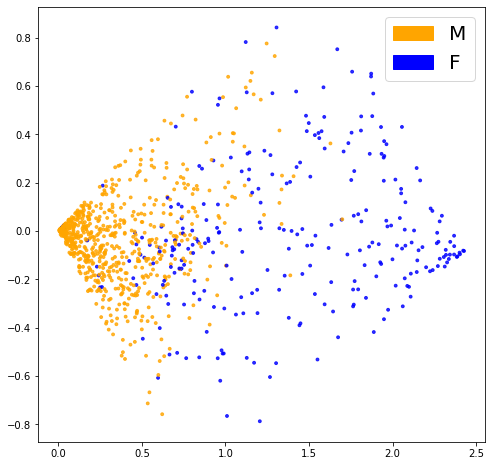

In [10]:
# Plot the test data along the 2 dimensions of largest variance
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='M')
            blue_patch = mpatches.Patch(color='blue', label='F')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 20})

fig = plt.figure(figsize=(8, 8))          
plot_LSA(X, y_valid)
plt.show()

### Models Definition, Training & Validation

#### MLP Classifier

In [13]:
# Split the data for training 
x_train , x_validation, y_train , y_validation = train_test_split(X, y_valid, train_size=0.8, test_size=0.2,
                                                      random_state=0)

x_train = X
y_train = y_valid

# Define MLP Classifier:
## Activation function for the hidden layer: "rectified linear unit function"
## Solver for weight optimization: "stochastic gradient-based optimizer"
## Alpha: regularization parameter
## Learning rate schedule for weight updates: "gradually decreases the learning rate at each time step t using an inverse scaling exponent of power_t"
## Verbose: "True" in order to print progress messages to stdout.
## Early stopping: "True" in order to use early stopping to terminate training when validation score is not improving. It automatically sets aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs.

mlpClf = MLPClassifier(solver = 'adam', activation= 'relu' ,alpha = 0.01, verbose = True, early_stopping = True,
                         learning_rate = 'invscaling', max_iter = 400)

# K fold per la cross-validation
kf = KFold(n_splits = 2)

# Training and validation on all K folds
for train_indices, test_indices in kf.split(x_train):
    mlpClf.fit(x_train[train_indices], y_train[train_indices])
    print(mlpClf.score(x_train[test_indices], y_train[test_indices]))
    
mlpClf.fit(x_train,y_train)

kfold = KFold(n_splits=10)
results = cross_val_score(mlpClf, x_train, y_train, cv=kfold, scoring='roc_auc')
np.mean(results)

lrClf = LogisticRegression(class_weight = "balanced",solver = "saga",C = 0.1)  #modello
lrClf.fit(x_train,y_train)

logistic = LogisticRegression()
param_grid ={
     'penalty' : ['l1', 'l2'],
    'C' : [1, 0.1,0.01,0.001,0.0001,0.00001,0.000001,10,100,2,3,2.6],
    "class_weight" : ["balanced",],
    'solver' : [ 'liblinear', 'saga']}
    
clf = GridSearchCV(logistic, param_grid = param_grid, cv = 10, scoring = "roc_auc" ,verbose=True, n_jobs=-1)
clf.fit(x_train,y_train)

clf.best_score_

clf.best_params_

kfold = KFold(n_splits=10)
results = cross_val_score(lrClf, x_train, y_train, cv=kfold, scoring='roc_auc')
np.mean(results)

y_scorel = lrClf.predict_proba(x_validation)[:,1]

y_scorem = mlpClf.predict_proba(x_validation)[:,1]

Iteration 1, loss = 0.66293915
Validation score: 0.840000
Iteration 2, loss = 0.65028078
Validation score: 0.880000
Iteration 3, loss = 0.63818800
Validation score: 0.880000
Iteration 4, loss = 0.62629728
Validation score: 0.860000
Iteration 5, loss = 0.61474611
Validation score: 0.840000
Iteration 6, loss = 0.60346301
Validation score: 0.840000
Iteration 7, loss = 0.59247897
Validation score: 0.840000
Iteration 8, loss = 0.58167093
Validation score: 0.840000
Iteration 9, loss = 0.57132121
Validation score: 0.840000
Iteration 10, loss = 0.56101374
Validation score: 0.840000
Iteration 11, loss = 0.55099848
Validation score: 0.840000
Iteration 12, loss = 0.54099823
Validation score: 0.840000
Iteration 13, loss = 0.53129751
Validation score: 0.840000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
0.86
Iteration 1, loss = 0.78816115
Validation score: 0.280000
Iteration 2, loss = 0.77377382
Validation score: 0.280000
Iteration 3, loss = 0.759331

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='invscaling',
              learning_rate_init=0.001, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [ ]:
# ROC curve for validation data 
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_validation, y_scorel)
roc_auc = auc(fpr, tpr) 


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('lrClf')
plt.legend(loc="lower right")
plt.show()

##### ROC Visualization 

In [ ]:
# Roc Curve for validation data 
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_validation, y_scorem)
roc_auc = auc(fpr, tpr) 


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('mlpClf')
plt.legend(loc="lower right")
plt.show()

#### XGBRegressor

In [ ]:
#clf = SVC(kernel='linear').fit(X_train, y_train)
my_model = XGBRegressor(objective = "reg:logistic",n_estimators=10000, learning_rate=0.05, n_jobs=4)
my_model.fit(x_train, y_train,
             eval_metric = "auc",
             early_stopping_rounds=100,
             eval_set=[(x_validation, y_validation)],
             verbose=False)

my_model.best_iteration

kfold = KFold(n_splits=10)
results = cross_val_score(my_model, x_train, y_train, cv=kfold, scoring='roc_auc')
np.mean(results)

y_score = my_model.predict(x_validation)
#y_score

##### ROC Visualization 

In [ ]:
# Roc Curve for validation data 
fpr, tpr, thresholds = roc_curve(y_validation, y_score)
roc_auc = auc(fpr, tpr) 

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB')
plt.legend(loc="lower right")
plt.show()